# Trabajo Semanal 9

## Parte 1 - Diseño de filtros

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib as mpl
import matplotlib.pyplot as plt


# Setup inline graphics
mpl.rcParams['figure.figsize'] = (10,10)

### Datos y Plantilla

In [2]:
fs = 1000

#Plantilla
fpass = np.array( [3, 25] )
ripple = 5 # dB
fstop = np.array( [1, 35] )
attenuation = 45 # dB

### Creación de filtro IIR

In [3]:
#Obtengo orden y frecuencias donde la atenuación es 3dB
order_IIR, wcutofz = sig.buttord( fpass, fstop, ripple, attenuation, analog=False, fs=fs)

#Obtengo coeficientes del filtro IIR
SOS_IIR = sig.iirfilter(order_IIR, wcutofz, rp=None, rs=attenuation, btype='bandpass', analog=False, ftype='butter', output='sos', fs=fs)

wz_target = np.linspace(0.00001,100,400)
wz_IIR, H_IIR = sig.sosfreqz(SOS_IIR,wz_target,fs=fs)

ganancia = 10**(5/20) #5dB

### Creación de filtro FIR

In [4]:
cant_coeff_FIR = 1501
bands = [0,1,3,25,27,fs/2]
desired = [0,0,1,1,0,0]
coeff_FIR = sig.firls(cant_coeff_FIR, bands, desired, weight=None, nyq=None, fs=fs)

wz_FIR, H_FIR = sig.freqz(coeff_FIR,1,wz_target,fs=fs)

### Respuesta de módulo, fase, y retardo de grupo

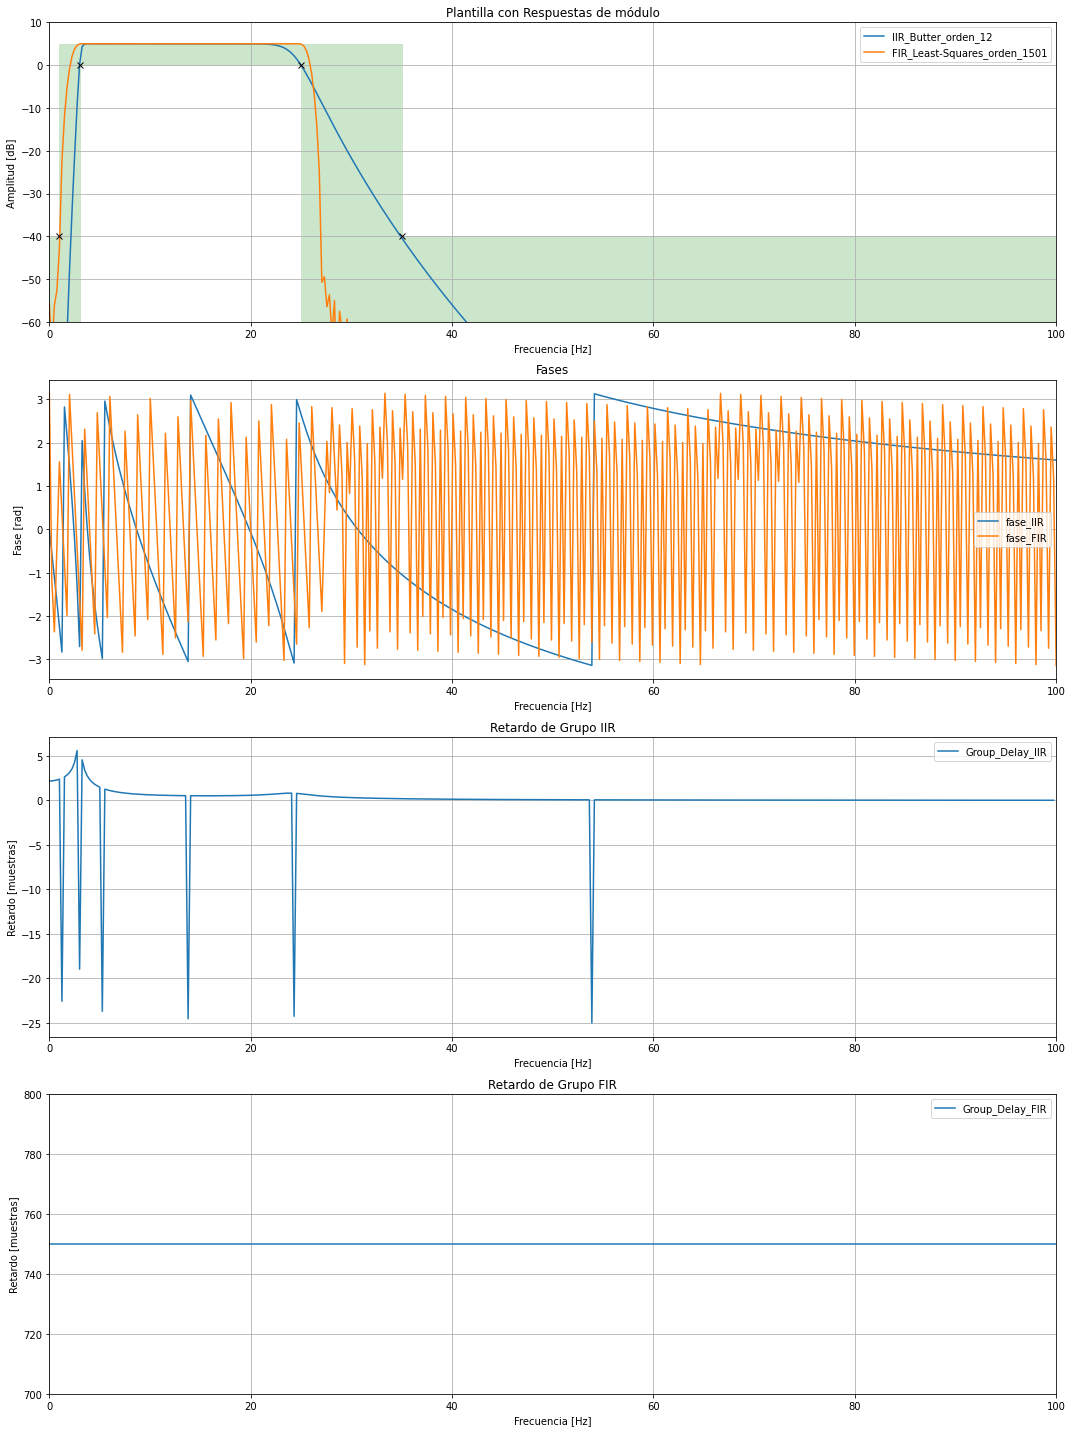

In [5]:
fig, ax = plt.subplots(4,1, figsize = (15,20))
ax[0].plot(wz_IIR, 20*np.log10(np.abs(H_IIR*ganancia)), label = 'IIR_Butter_orden_%d' %order_IIR)
ax[0].plot(wz_FIR, 20*np.log10(np.abs(H_FIR*ganancia)), label = 'FIR_Least-Squares_orden_%d' %cant_coeff_FIR)
ax[0].set_title('Plantilla con Respuestas de módulo')
ax[0].set_xlabel('Frecuencia [Hz]')
ax[0].set_ylabel('Amplitud [dB]')
ax[0].grid()
ax[0].set_xlim([0,100])
ax[0].set_ylim([-60,10])
ax[0].legend()

#ploteo plantilla
ax[0].fill([0, 1, 1,35,35,100,100,25,25,3,3,0],[-40,-40,5,5,-40,-40,-60,-60,0,0,-60,-60],color=[0.8,0.902,0.8])
ax[0].plot(1,-40,3,0,25,0,35,-40, marker='x', color = 'k')

#Fase
ax[1].plot(wz_IIR, np.angle(H_IIR*ganancia), label = 'fase_IIR')
ax[1].plot(wz_FIR, np.angle(H_FIR*ganancia), label = 'fase_FIR')
ax[1].set_title('Fases')
ax[1].set_xlabel('Frecuencia [Hz]')
ax[1].set_ylabel('Fase [rad]')
ax[1].grid()
ax[1].set_xlim([0,100])
ax[1].legend()

#Retardo de grupo IIR
D_IIR = -np.diff(np.angle(H_IIR))/np.diff(wz_IIR)
ax[2].plot(wz_IIR[0:(len(wz_IIR)-1)], D_IIR, label = 'Group_Delay_IIR')
ax[2].set_title('Retardo de Grupo IIR')
ax[2].set_xlabel('Frecuencia [Hz]')
ax[2].set_ylabel('Retardo [muestras]')
ax[2].grid()
ax[2].set_xlim([0,100])
ax[2].legend()
#Retardo de grupo FIR
wz_FIR, D_FIR = sig.group_delay((coeff_FIR,1), w=wz_FIR, fs = fs)
ax[3].plot(wz_FIR, D_FIR, label = 'Group_Delay_FIR')
ax[3].set_title('Retardo de Grupo FIR')
ax[3].set_xlabel('Frecuencia [Hz]')
ax[3].set_ylabel('Retardo [muestras]')
ax[3].grid()
ax[3].set_xlim([0,100])
ax[3].set_ylim([700,800])
ax[3].legend()

plt.tight_layout()

## Parte II - Implementación y uso

Una vez diseñados los filtros procedemos a utilizarlos. Para ello SciPy dispone de dos implementaciones de la ecuación de diferencias, la tradicional mediante **lfilter** y la variante por SOS's mediante **sosfilt**. La primera puede usarse para filtros FIR de cualquier tamaño, e IIR de bajo orden (<= 3 secciones u orden 6), mientras que la segunda es **obligatoria** para filtros IIR de orden superior.

In [6]:
import scipy.io as sio


fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

nyq_frec = fs / 2

# IIR
ECG_f_IIR = sig.sosfilt(SOS_IIR, ecg_one_lead)

# FIR
ECG_f_FIR = sig.lfilter(coeff_FIR, 1, ecg_one_lead)


Ahora visualizamos los resultados, para ello se cuenta con diferentes regiones de interés (ROI's) para poder evaluar qué tan bien se comportan los filtros diseñados. Primero revisaremos zonas de **alta contaminación** para evaluar qué tan eficiente es el filtrado.

Recordar que **cada filtro impone una demora a la señal filtrada**, por lo tanto, dicha demora puede corregirse para cada filtro retrasando la señal de entrada o adelantando la señal de salida. Recuerde que como la señal ya fue registrada, una secuencia puede *adelantarse*.

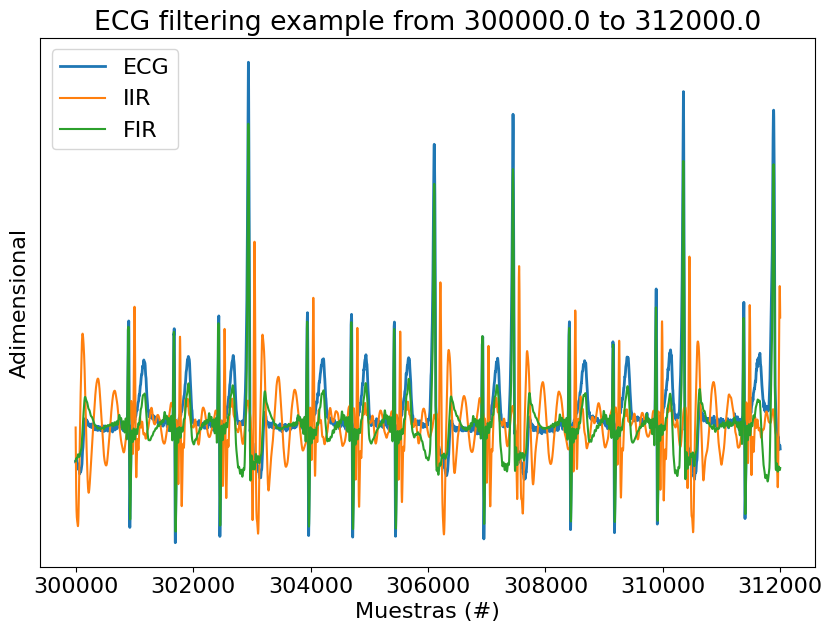

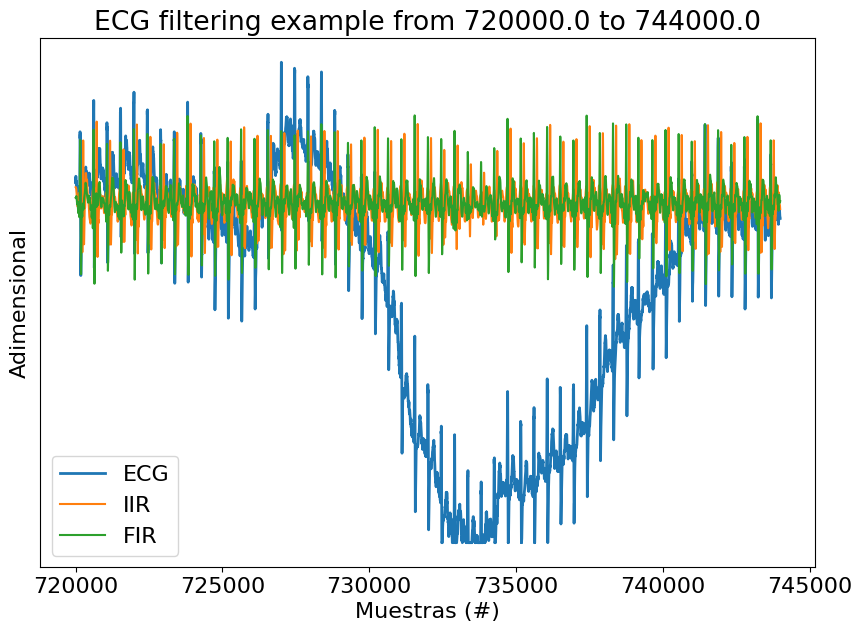

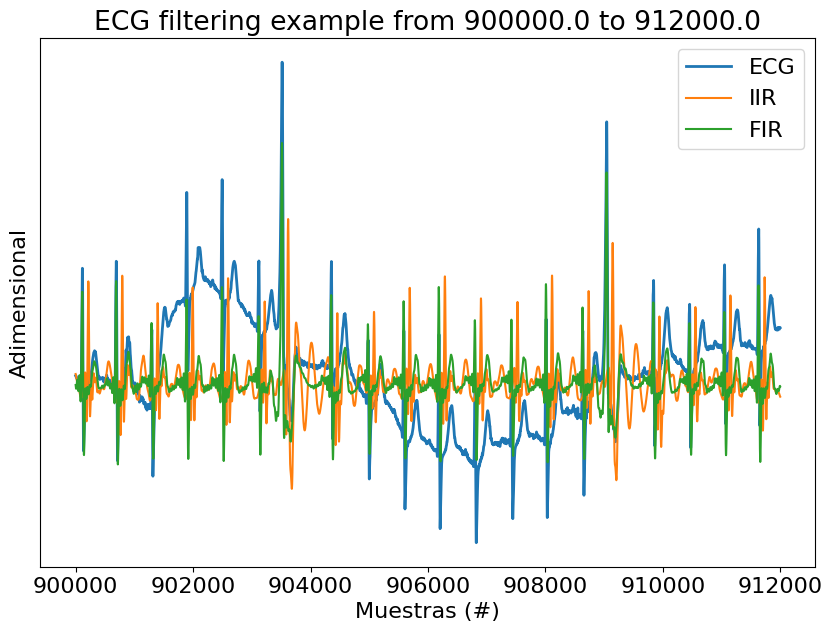

In [7]:
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_IIR[zoom_region], label='IIR')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Dicha contaminación probablemente se deba al aumento de la actividad física durante la prueba de esfuerzo. Como se observa, la mayor parte de las técnicas de filtrados es *inocua* cuando no hay contaminación de baja frecuencia, y remueve los movimientos de la línea de base correctamente.

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos **con baja contaminación**, es decir qué tan **inocuo** es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico. 

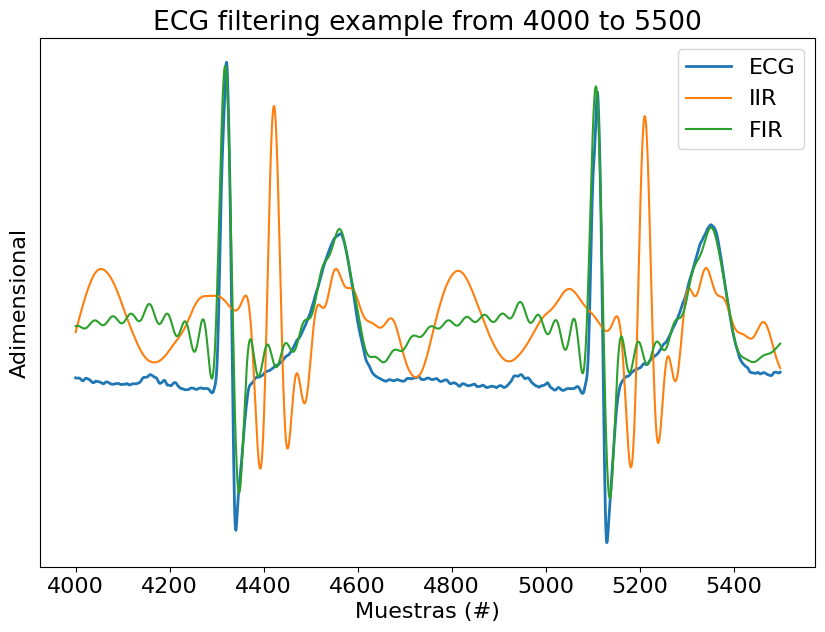

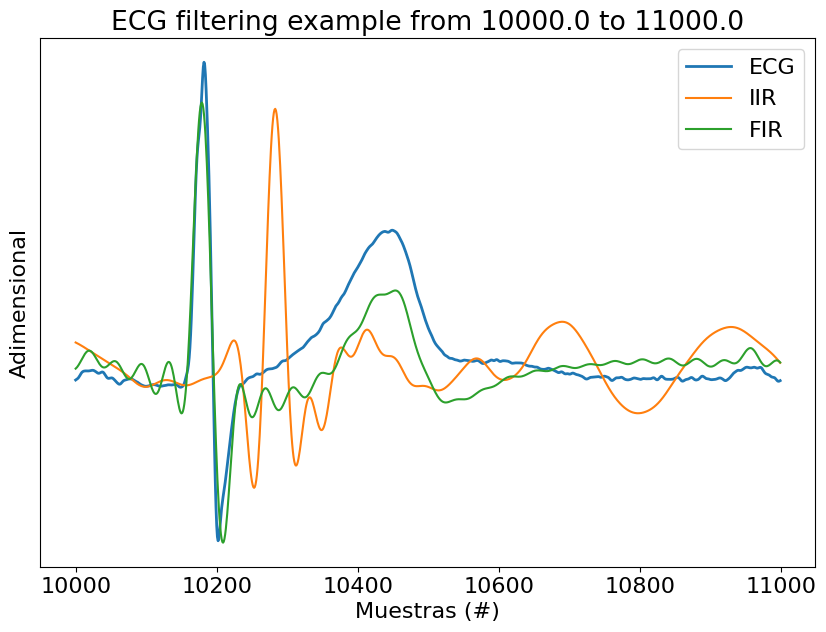

In [8]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_IIR[zoom_region], label='IIR')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Finalmente implementaremos **los mismos filtros** con una técnica diferente llamada *filtrado bidireccional* *[scipy.signal.filtfilt](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html)*.

El filtrado bidireccional es una técnica sumamente conveniente al momento de filtrar digitalmente una señal, dado que evita por completo cualquier distorsión de fase. Esto afecta principalmente a los filtros IIR, donde las distorsiones pueden ser notorias. Sin embargo, los filtros FIR cuya respuesta al impulso sea simétrica (par o simpar), **no** producen distorsión de fase debido a que su fase **es lineal**. 

En ambos casos, tanto para los IIR como para los FIR, simétricos o no, el resultado es una anulación completa de la respuesta de fase, obteniéndose así un **filtro de fase cero**. Recordemos que la transformada de Fourier de la inversión en tiempo es 

\begin{equation}
x[-k] \stackrel{\mathrm{DFT}}{\longleftrightarrow} X^*(e^{j \, \Omega })
\end{equation}

Por lo tanto, vemos que la inversión en tiempo conlleva la negación de la respuesta de fase de una señal. Entonces utilizaremos una doble inversión temporal para cancelar los efectos de fase, y al mismo tiempo el resultado neto sobre la señal espejada dos veces será nulo

\begin{equation}
Y(e^{j \, \Omega }) = X(e^{j \, \Omega }) \cdot T^*(e^{j \, \Omega }) \cdot T(e^{j \, \Omega }) 
\end{equation}

\begin{equation}
Y = X \cdot |T|^2
\end{equation}

*(Se simplificó la notación para clarificar el resultado)* Se observa como resultado de aplicar el método bidireccional un filtro equivalente al cuadrado del módulo y con aporte nulo de fase para todas las frecuencias. Esto equivale a haber atravesado dos veces por el mismo filtro, por lo tanto la atenuación será el doble que la del filtro original (y el *ripple* en banda también!) razón por lo cual debe modificarse la plantilla de diseño **relajando a la mitad** la atenuación, es decir exigiendo menos atenuación, pero **duplicando** la exigencia de ripple, es decir dividiendo por dos el ripple.

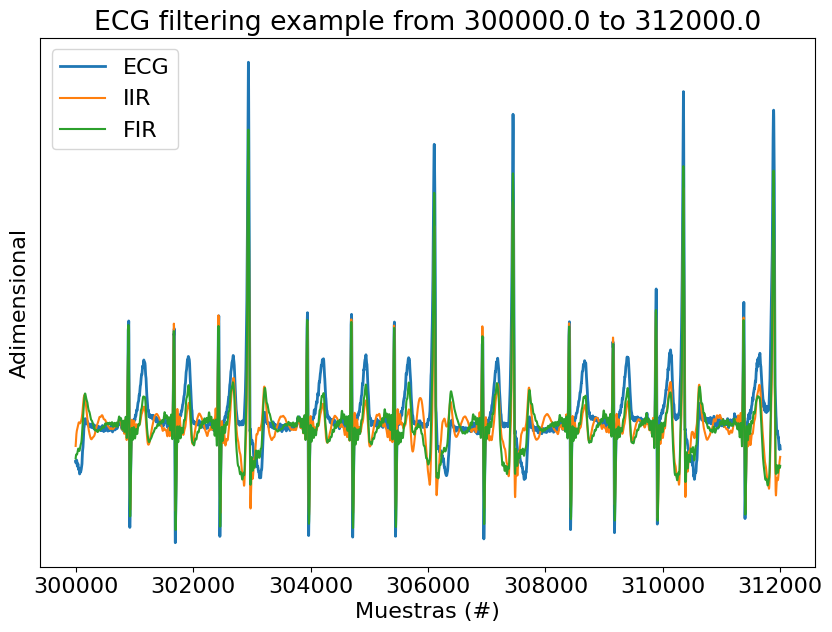

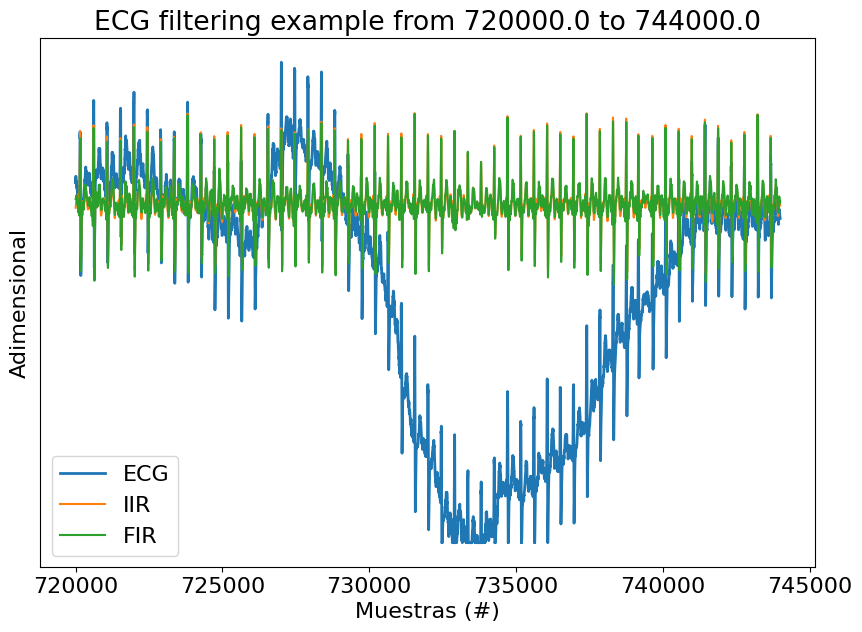

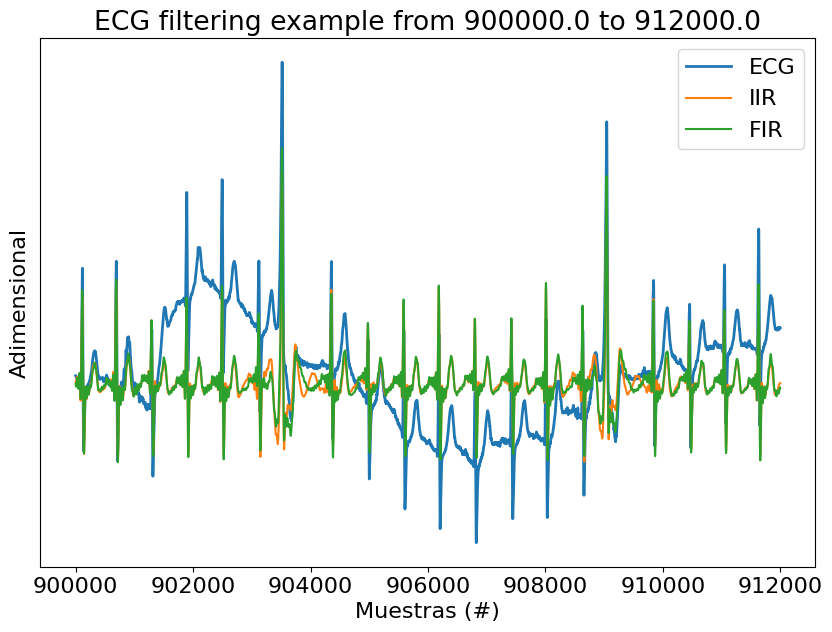

In [9]:
# Procedemos al filtrado

ECG_f_IIR = sig.sosfiltfilt(SOS_IIR, ecg_one_lead)

ECG_f_FIR = sig.filtfilt(coeff_FIR, 1, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_IIR[zoom_region], label='IIR')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Volvemos a revisar los detalles menos contaminados:

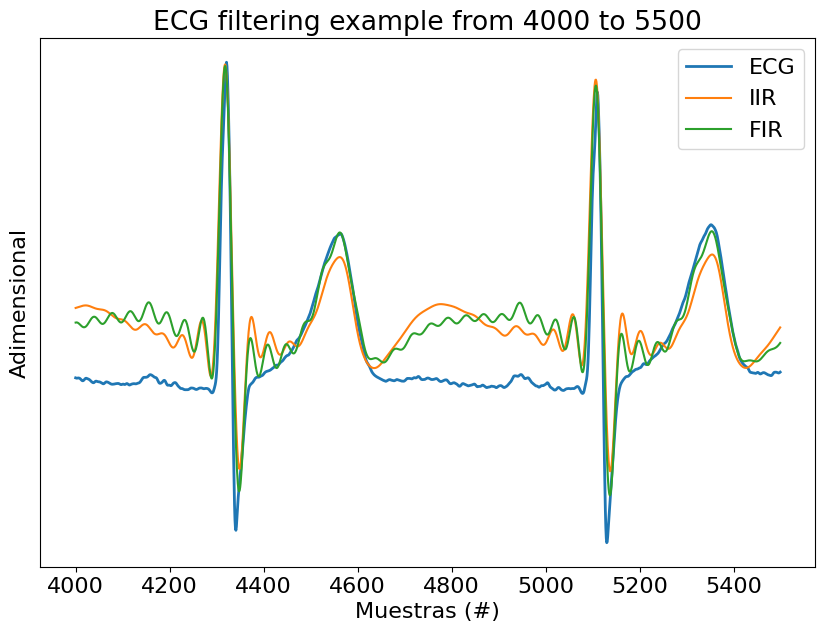

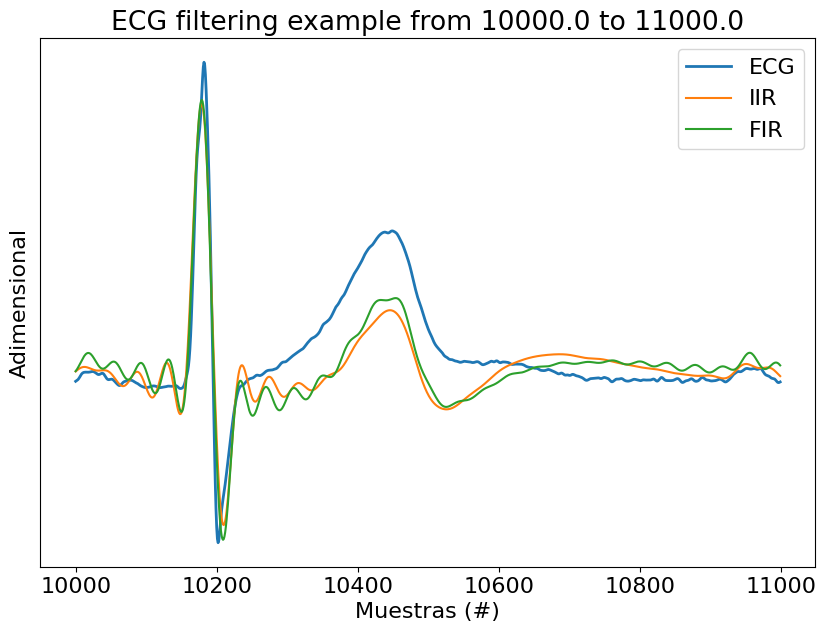

In [10]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_IIR[zoom_region], label='IIR')
    plt.plot(zoom_region, ECG_f_FIR[zoom_region], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se observa, la señal de ECG ha sido alterada en su morfología, a pesar de que **la fase no pudo haber sido la responsable** luego de haber usado el filtrado bidireccional. El complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía relacionadas con la compresión muscular, han sido claramente atenuadas, mientras que la onda T, la segunda onda positiva de mayor duración y relacionada con la relajación muscular, ha sido también atenuada. También se observan otros artefactos ocasionados por el filtrado lineal, como **oscilaciones que no estaban presentes en el ECG original**. Estas observaciones dan cuenta, que estos filtros no son adecuados para esta tarea y es necesario su rediseño teniendo en cuenta estos aspectos.
  